In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import cvxpy as cp
from sklearn.metrics import mean_squared_error as mse
import datetime
import scipy
import gc
import matplotlib.pyplot as plt
from scipy import stats

from app.historical_price import HistoricalPrice
from app.random_variable import RandomVariable

In [2]:
hp = HistoricalPrice()
daily_returns = hp.get_all_returns(freq='daily')
# weekly_returns = hp.get_all_r|eturns(freq='weekly').filter(items=daily_returns.columns,axis=1)
# weekly_returns.shape,daily_returns.shape

In [3]:
tickers = pd.read_csv('data/tickers.csv',index_col=0)

recession_proof = (tickers['sector'].isin(['Health Technology','Consumer Non-Durables','Technology Services']))
insurance = (tickers['industry'].str.contains("Insurance"))
non_footwear = (tickers['industry']=="Apparel/Footwear")
tickers = tickers.loc[recession_proof|insurance]
tickers = tickers.loc[~non_footwear]

weekly_returns = weekly_returns.filter(items=tickers['ticker'],axis=1)
daily_returns = daily_returns.filter(items=tickers['ticker'],axis=1)
tickers


KeyError: 'sector'

#### Filtering assets 
- Exclude if skew >= 0. This will also leave us with assets that are generally increaseing in value but have rarer and larger losses. 

In [4]:
skew = pd.DataFrame(None,columns=['median_w','stat_w','pval_w','median_d','stat_d','pval_d'])

for stock in weekly_returns.columns:
    stat,pval = stats.skewtest(weekly_returns[stock].dropna())
    skew.loc[stock,"stat_w"] = stat
    skew.loc[stock,"pval_w"] = pval
    skew.loc[stock,'median_w'] = weekly_returns[stock].dropna().median()
    
    stat,pval = stats.skewtest(daily_returns[stock].dropna())
    skew.loc[stock,"stat_d"] = stat
    skew.loc[stock,"pval_d"] = pval
    skew.loc[stock,'median_d'] = daily_returns[stock].dropna().median()
    
#### Negative skewness statistic means that the prob distribution is negatively skewed 
#### meaning that the left tail is longer but the mass of the distribution is concentrated
#### on the right. Thus we can exclude postive skew assets to reduce the asset universe.
skew = skew.sort_values(by=['stat_w','stat_d'],ascending=False)

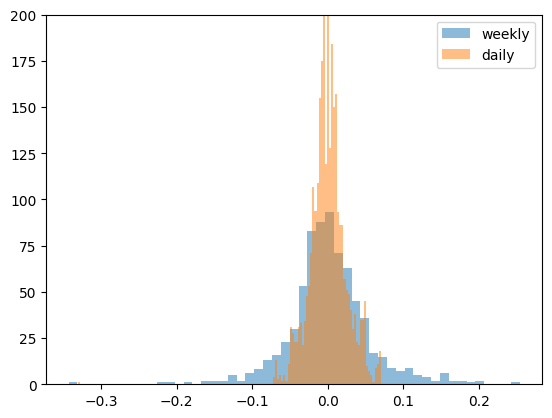

In [5]:
s = 'MSN'
plt.hist(weekly_returns[s].values, bins='auto', alpha=0.5, label='weekly')
plt.hist(daily_returns[s].values, bins='auto', alpha=0.5, label='daily')
plt.legend(loc='upper right')
plt.gca().set_ylim([0,200])
plt.show()

In [6]:
### stocks that are neg-skewed weekly but positively-skewed daily ...
### over the daily horizon it may seems like they're decreasing, 
### but actually they're increasing on a weekly basis

### it means that over the course of one week, the number of daily negative returns
### will be more, but there will be 1 or 2 days where the positive returns will be large
### enough to offset the negative returns such that the weekly return is positive 
skew[(skew['stat_w']<0)&(skew['stat_d']>0)].tail()

,median_w,stat_w,pval_w,median_d,stat_d,pval_d
MIG,0.0,-2.512847,0.011976,0.0,0.020716,0.983473


In [7]:
### On the other hand assets with positively weekly skew and negative daily skew
### means that there are more days where they are increasing within the week
### but there will be 1 or 2 days where the where the returns will be negative enough 
### to offset the increasing days
skew[(skew['stat_w']>0)&(skew['stat_d']<0)].head()

,median_w,stat_w,pval_w,median_d,stat_d,pval_d
SCD,0.0,6.980696,0.0,0.0,-1.272323,0.203258
CMG,0.0,5.226597,0.0,0.0,-1.251521,0.210745
BMI,0.0,4.312436,0.000016,0.0,-4.213372,0.000025
ELC,-0.003276,2.763768,0.005714,0.0,-0.702063,0.48264
DBT,0.0,2.411354,0.015893,0.0,-27.13761,0.0


In [17]:
posskewed_assets = skew.loc[skew['stat_w']>=0].index
returns = daily_returns.drop(columns = posskewed_assets)
print(returns.shape)

### Skewness based on frequency 
######## TOTAL 392 assets
## Daily: 264 assets are neg-skewed (max periods 4240) 
## Weekly: 155 assets are neg-skewed (max periods 1193) 
## Fortnightly: 94 assets are neg-skewed (max periods 602) 
## Monthly: 63 assets are neg-skewed (max periods 277) 
######## REDUCE asset universe via weekly skewness, 
######## but perform portfolio optimization via daily returns

(5402, 14)


In [18]:
for s in returns.columns:
    print(s,np.quantile(returns[s].dropna(),0.5))

ABT 0.0
ANV 0.0
ASM 0.0
DBD 0.0
DHG 0.0
FPT 0.0
KDC 0.0
LIX 0.0
MIG 0.0
MSN 0.0
OPC 0.0
TRA 0.0
VHC 0.0
VNM 0.0


### Mean-Variance Optimization

In [11]:
## Risk-free rate as bank saving rate (assume 6% pa)
rf_rate = (1+0.06)**(1/365)-1


# average returns
mu = returns.mean().values

## covariance 
cov = returns.cov().values

# variable to optimize over - portfolio weights
w = cp.Variable(len(mu))

######## objectives to optimize
# portfolio return
R = mu.T @ w 

prob = cp.Problem(cp.Maximize(R),   ## Maximize return 
                  [   
                   cp.sum(w) == 1,   # sum of weights = 1
                   w >= 0,          # weights > 0 (long-only)
                  ]      
                 )
prob.solve()
portfolio_weights = prob.variables()[0].value
portfolio_return = portfolio_weights.dot(mu)
portfolio_volatility = portfolio_weights.T.dot(cov).dot(portfolio_weights)

sharpe = (portfolio_return-rf_rate)/np.sqrt(portfolio_volatility)
portfolio_return, portfolio_volatility, sharpe

(0.0004666385790395737, 0.0008342758871817934, 0.010628263124241368)

In [156]:
#### No need to invest in everything
#### Investing in 10 stocks is diversified enough

#### Also the covariance matrix is not positive-definite,
#### and so the optimization problem is non-convex.
#### Constraining the number of stocks takes care of this problem.

results = pd.DataFrame(None,columns=['r','return','volatility'])
weights_memory = {}

n = returns.shape[1]
## 364C10 is very large number of possible combinations, 
## need to reduce asset universe via FUNDAMENTALS

for r in np.arange(0,0.001,0.00001):
    #### THE Covariance matrix is not positive-definite
    #### the optimization problem is not a convex one.

    temp_returns = returns.sample(n,axis=1)
    assets = "_".join(temp_returns.sort_index(axis=1).columns)
    temp_cov = temp_returns.cov().values

    # average returns
    mu = temp_returns.mean().values

    # variable to optimize over - portfolio weights
    w = cp.Variable(n)

    ######## objectives to optimize
    # portfolio return
    R = mu.T @ w 
    Var = cp.quad_form(w, temp_cov)
    
    try:
        prob = cp.Problem(cp.Minimize(Var),   ## minimize volatility
                          [
                           R >= r,
                           cp.sum(w) == 1,   # sum of weights = 1
                           w >= 0.05,            # weights > 0 (long-only)
                           w <= 0.4          ## no equity can take up more than 30%, avoid over-concentration
                          ]      
                         )
        prob.solve(solver='CVXOPT')
        portfolio_weights = prob.variables()[0].value
        portfolio_return = portfolio_weights.dot(mu)
        portfolio_volatility = portfolio_weights.T.dot(temp_cov).dot(portfolio_weights)
        results.loc[len(results)]= [r,portfolio_return,portfolio_volatility]
        weights_memory[np.around(r,5)] = portfolio_weights
    except Exception as e:
        # print(e)
        continue

#### CALCULATING SHARPE RATIO
results['sharpe'] = (results['return']-rf_rate) / np.sqrt(results['volatility'])
results =results.sort_values(by=['sharpe'],ascending=False)
results.head(10)

,r,return,volatility,sharpe
25,0.00025,0.000250,0.000125,0.008076
24,0.00024,0.000240,0.000102,0.007945
23,0.00023,0.000230,0.000099,0.007079
22,0.00022,0.000220,0.000097,0.006123
21,0.00021,0.000210,0.000097,0.005135
18,0.00018,0.000209,0.000097,0.005067
19,0.00019,0.000209,0.000097,0.005059
17,0.00017,0.000209,0.000097,0.005058
0,0.00000,0.000209,0.000097,0.005051
1,0.00001,0.000209,0.000097,0.005043


In [157]:
weights_memory[0.00025]

array([0.18067595, 0.05000008, 0.0500001 , 0.05000009, 0.21932218,
       0.05000021, 0.05000022, 0.05000037, 0.05000005, 0.05000027,
       0.05000006, 0.05000007, 0.05000005, 0.0500003 ])

In [158]:
#### Mean, CVaR on actual returns 
alpha = 0.1

loss = returns.dot(weights_memory[0.00025]).dropna()
VaR = -np.quantile(loss,alpha)
mean = np.mean(loss)
median = np.median(loss)
CVaR = loss[loss > VaR].sum()*(1/(len(loss)*(1-alpha))) + VaR
mean,median,VaR,CVaR

(0.00020911294006738845,
 0.0008188473260155489,
 0.012137556764210567,
 0.014025799264138772)

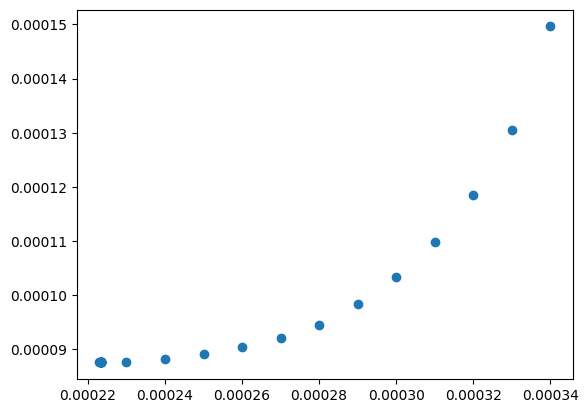

In [38]:
import matplotlib.pyplot as plt
plt.scatter(results['return'], results['volatility'])
plt.show()

## CVaR optimization 

1) Obtain VaR from each asset based on Monte Carlo Simulation from the fitted parametric Generalized Hyperbolic Distribution. 
2) We can then initialize the portfolio weights as uniform across all assets. Then we can calculate the loss distribution based the Monte Carlo distribution obtained from step 1. (However we're assuming that the assets are uncorrelated, they are not)  

In [39]:
# from copulas.multivariate import VineCopula
import pyvinecopulib as pv
import seaborn as sns
from scipy.stats import nct, laplace_asymmetric ,genhyperbolic, laplace , t, gennorm

Index(['LIX', 'DBD', 'MIG', 'FPT', 'MSN', 'VNM', 'DHG', 'TRA', 'ABT', 'ASM',
       'VHC', 'OPC', 'ANV', 'KDC'],
      dtype='object')
[(3413,), (1670,), (1597,), (4141,), (3438,), (4366,), (4137,), (3669,), (4124,), (3388,), (3889,), (3687,), (3900,), (4386,)]


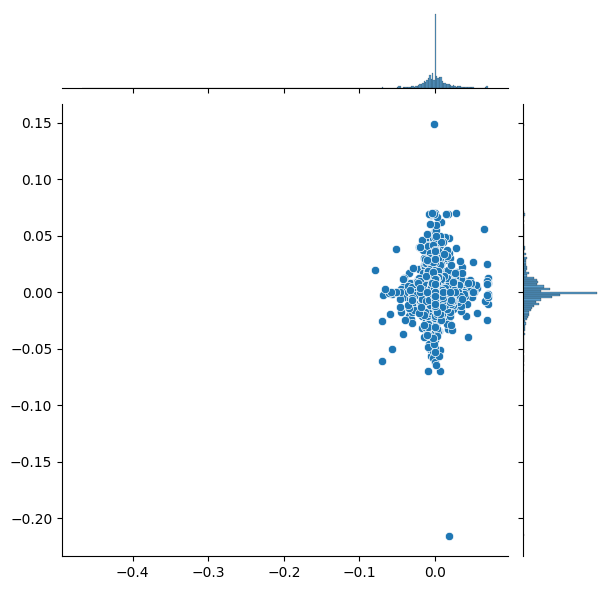

In [45]:
n= returns.shape[1]

X = returns.sample(n,axis=1)#.dropna()
variables = [RandomVariable(X.loc[:,i].dropna(),laplace_asymmetric) for i in X.columns]
uniform = [var.unif() for var in variables]

print(X.columns)
print([u.shape for u in uniform])
sns.jointplot(x=X.values[:,0],y=X.values[:,1])

In [46]:
data = pd.DataFrame(np.vstack((u[-1100:] for u in uniform)).T,columns=X.columns)
cop = pv.Vinecop(data=data)
print(cop.loglik(),cop.aic())

1583.7443854912779 -2387.2021634212347


In [47]:
sample = cop.simulate(n=10000,num_threads = 100)
print(sample[sample>1])
print(sample[sample<0])
sample.shape

[]
[]


(10000, 14)

In [48]:
for i in range(sample.shape[1]):
    sample[:,i] = variables[i].transform(sample[:,i])

print(sample[sample>1])
print(sample[sample<-1])
# del uniform, variables, data, cop
# gc.collect()

[]
[]


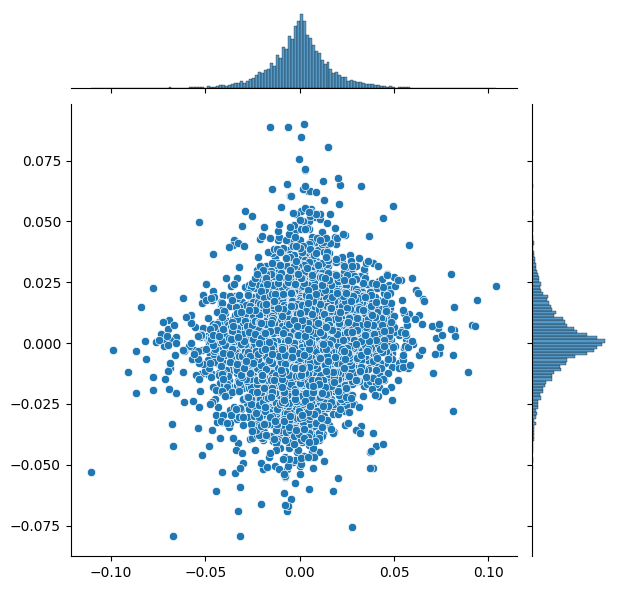

In [54]:
sns.jointplot(x=sample[:,0],y=sample[:,1])

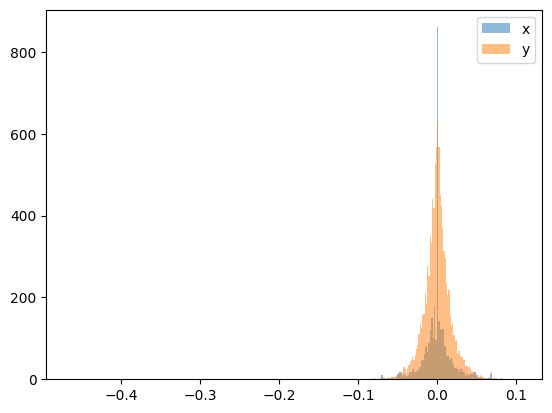

In [55]:
plt.hist(X.values[:,0], bins='auto', alpha=0.5, label='x')
plt.hist(sample[:,0], bins='auto', alpha=0.5, label='y')
plt.legend(loc='upper right')
plt.show()

In [56]:
### initialize portfolio weights
w = np.array([1/n for i in range(n)])
# w = w.value
loss = sample.dot(w)

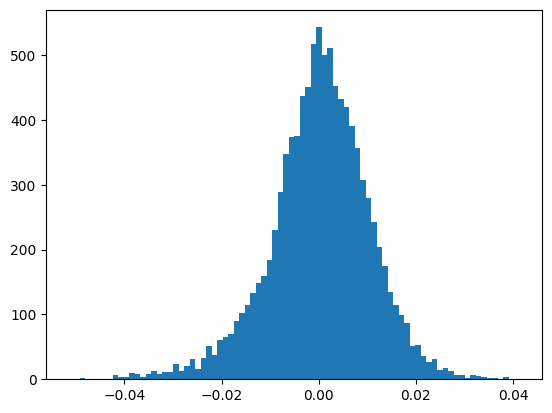

In [57]:
plt.hist(loss, bins='auto')
plt.show()

In [58]:
alpha = 0.1
VaR = -np.quantile(loss,alpha)
VaR

0.012595335864651757

In [59]:
# Import packages.
import cvxpy as cp
import numpy as np

# Define and solve the CVXPY problem.
sample_size = 10000

mu = np.mean(sample,axis=0)
w = cp.Variable(n)
z = cp.Variable(sample_size)
x = sample
y = cp.Variable(n,boolean=True)
obj = VaR + (1/(sample_size*(1-alpha)))*cp.sum(z)

prob = cp.Problem(cp.Minimize(obj),
                 [ 
                  z >= 0, 
                  z >= -x@w - VaR,
                  w.T@mu >= 0,
                  cp.sum(w) == 1,   # sum of weights = 1
                   w >= 0.02*y,          #  (long-only, minumum weight enforced to avoid w =0.0000001)
                   w <= 0.3*y         # avoid over-exposure to a single stock
                 ])
prob.solve(verbose=True,solver=cp.SCIPY,scipy_options={"method":"highs"})
print("\nThe optimal value is", prob.value)

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Nov 27 02:31:06 AM: Your problem has 10028 variables, 6 constraints, and 0 parameters.
(CVXPY) Nov 27 02:31:06 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 27 02:31:06 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 27 02:31:06 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 27 02:31:06 AM: Compiling problem (target solver=SCIPY).
(CVXPY) Nov 27 02:31:06 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

In [60]:
expected_return = w.value.dot(mu)
expected_return,(1+expected_return)**250-1

(0.00021699819046305796, 0.055741815444244835)

# Loop 

In [248]:
alpha = 0.1
sample_size = 10000
results = pd.DataFrame(None,columns=['portfolio','weights','CVaR','r'])

variables = {r : RandomVariable(returns[r].dropna().values,laplace_asymmetric) for r in returns.columns}
uniform = {r: var.unif() for r,var in variables.items()} 
len(uniform)

14

In [249]:
## approx 250 trading days per year (review most recent 3 years only, every 6 months period) 
for p in range(125,875,125):
    print("\n")
    valid_cols = [r for r,u in uniform.items() if len(u) >= p]
    sub_uniform = [u[-p:] for r,u in uniform.items() if r in valid_cols]
    n=len(sub_uniform)

    print(n)
    data = pd.DataFrame(np.vstack(sub_uniform).T,columns=valid_cols)
    cop = pv.Vinecop(data=data)
    print("Vine Copula fitted")

    sample = cop.simulate(n=10000,num_threads = 100)
    for i,r in enumerate(valid_cols):
        sample[:,i] = variables[r].transform(sample[:,i])
    print("Monte Carlo sample obtained")

    del sub_uniform, data, cop
    gc.collect()

    ### initialize portfolio weights
    w = np.array([1/n for i in range(n)])
    loss = sample.dot(w)
    VaR = -np.quantile(loss,alpha)

    mu = np.mean(sample,axis=0)
    w = cp.Variable(n)
    z = cp.Variable(sample_size)
    x = sample
    y = cp.Variable(n,boolean=True)
    obj = VaR + (1/(sample_size*(1-alpha)))*cp.sum(z)

    prob = cp.Problem(cp.Minimize(obj),
                     [ 
                      z >= 0, 
                      z >= -x@w - VaR,
                      w.T@mu >= 0,
                      cp.sum(w) == 1,   # sum of weights = 1
                       w >= 0,#.05*y,          #  (long-only, minumum weight enforced to avoid w =0.0000001)
                       w <= 0.4*y,         # avoid over-exposure to a single stock
                       cp.sum(y) <= 8,
                         
                     ])
    prob.solve(solver=cp.SCIPY,scipy_options={"method":"highs"})
    if prob.status == 'optimal' and prob.value != float("inf"):
        new_row = {'portfolio':valid_cols,'weights':w.value,'CVaR':prob.value,'r':w.value.dot(mu)}
        results = results.append(new_row,ignore_index=True)
        print("Solution Obtained")
        print(results.iloc[:,2:])
    else:
        print("No Solution")





14
Vine Copula fitted
Monte Carlo sample obtained
Solution Obtained
       CVaR         r
0  0.013557  0.000293


14
Vine Copula fitted
Monte Carlo sample obtained
Solution Obtained
       CVaR         r
0  0.013557  0.000293
1  0.013481  0.000144


14
Vine Copula fitted
Monte Carlo sample obtained
Solution Obtained
       CVaR             r
0  0.013557  2.926167e-04
1  0.013481  1.436491e-04
2  0.013516  4.946672e-19


14
Vine Copula fitted
Monte Carlo sample obtained
Solution Obtained
       CVaR             r
0  0.013557  2.926167e-04
1  0.013481  1.436491e-04
2  0.013516  4.946672e-19
3  0.012775  2.575520e-04


14
Vine Copula fitted
Monte Carlo sample obtained
Solution Obtained
       CVaR             r
0  0.013557  2.926167e-04
1  0.013481  1.436491e-04
2  0.013516  4.946672e-19
3  0.012775  2.575520e-04
4  0.013461  2.217971e-04


14
Vine Copula fitted
Monte Carlo sample obtained
Solution Obtained
       CVaR             r
0  0.013557  2.926167e-04
1  0.013481  1.436491e-04
2 

In [251]:
i = 5

stocks = results.loc[i,['portfolio']].values[0]
weights = results.loc[i,['weights']].values[0]
allocation  = list(zip(stocks,weights))
allocation = [(s,w) for (s,w) in allocation]# if w > 0 ]
stocks = [s for (s,w) in allocation]
weights = [w for (s,w) in allocation]

for w,s in zip(weights,stocks):
    print(w,s)

0.13365943782829484 ABT
-0.0 ANV
-0.0 ASM
0.2650012292616325 DBD
0.04141153271020746 DHG
-0.0 FPT
-0.0 KDC
0.15502909930651834 LIX
-0.0 MIG
0.0600365273621767 MSN
0.15038592834338568 OPC
0.11422308477932878 TRA
-0.0 VHC
0.0802531604084386 VNM


In [245]:
# tickers.loc[tickers['ticker'].isin(stocks)]

# ## CANDIATES: ABT, DBD, LIX, OPC, TRA (VNM ? )

### Double check Allocated Portfolio

In [246]:
allocation_daily = daily_returns.loc[:,stocks]
# allocation_weights = np.repeat(1/len(stocks), len(stocks))
allocation_weights = weights.copy()
allocation_daily.tail()

,ABT,ANV,ASM,DBD,DHG,FPT,KDC,LIX,MIG,MSN,OPC,TRA,VHC,VNM
date,,,,,,,,,,,,,,
2023-11-20,0.0,0.003344,-0.005411,0.000000,-0.004803,-0.003297,0.001577,0.000000,0.000000,-0.007800,-0.006522,0.000000,-0.015471,-0.010000
2023-11-21,0.0,0.015000,0.007617,0.000000,0.015444,0.013230,-0.007874,0.020408,-0.002857,0.015723,0.002188,0.000000,0.014286,0.002886
2023-11-22,0.0,0.018062,0.003240,-0.003478,-0.006654,0.011970,0.001587,0.000000,0.002865,0.004644,-0.004367,0.000000,0.000000,-0.001439
2023-11-23,0.0,-0.032258,-0.004306,-0.010471,-0.014354,-0.023656,0.004754,0.000000,0.000000,-0.024653,0.004386,-0.005000,-0.021127,-0.010086
2023-11-24,0.0,0.000000,-0.009730,0.000000,-0.002913,0.004405,-0.006309,-0.010000,-0.005714,-0.023697,-0.004367,-0.007538,0.000000,-0.005822


In [247]:
loss = allocation_daily.dot(allocation_weights).dropna()
VaR = -np.quantile(loss,alpha)
mean = np.mean(loss)
median = np.median(loss)
CVaR = loss[loss > VaR].sum()*(1/(sample_size*(1-alpha))) + VaR

cv = np.array([mean,median, VaR, CVaR])
cv

array([0.00018735, 0.00027501, 0.01084186, 0.01113271])

In [ ]:
## CVAR, restricited weights, max 5 stocks 
array([0.00018735, 0.00027501, 0.01084186, 0.01113271]) ## mean return >= 0
array([0.00019523, 0.0002707 , 0.01074209, 0.0110234 ]) ## mean return >= 0.00015
array([0.00019456, 0.00034095, 0.01067915, 0.01097426]) ## mean return >= 0.0002
array([0.00019622, 0.00037825, 0.01081129, 0.01110465]) ## mean return >= 0.00025
array([0.00019907, 0.00028063, 0.01118421, 0.01150606]) ## mean return >= 0.0003

In [176]:
## CVAR portfolio uniform weights
uw = np.array([0.00028118, 0.00113856, 0.01152144, 0.01179259])
uw

array([0.00028118, 0.00113856, 0.01152144, 0.01179259])

In [169]:
## MEAN VARIANCE PORTFOLIO
mv = np.array([0.00020911294006738845,
 0.0008188473260155489,
 0.012137556764210567,
 0.014025799264138772])
mv

array([0.00020911, 0.00081885, 0.01213756, 0.0140258 ])

In [177]:
uw/mv

array([1.34463224, 1.39044235, 0.94923882, 0.84077847])